In [40]:
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy.exc import SQLAlchemyError
from ml_functions import *
from sklearn.metrics import accuracy_score, recall_score
from db_queries import username, password, dsn, dbhostname, service_name, dbtables, querys
from table_functions import *
import mlflow
import mlflow.pyfunc

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# DGM id - oni id_dmc
# DGM dmc - MEB_DMC dmc_casting

def read_last_meb_dgm(last_id = 0):

    data = {}
    if last_id:
        query = f"""SELECT *
            FROM (
                SELECT
                    t.*,
                    ROW_NUMBER() OVER (PARTITION BY DMC ORDER BY ID DESC) AS rn
                FROM
                    Z3DMC.MEB_DGM t
            ) subquery
            WHERE rn = 1
            AND id > {last_id}"""

    else:
        query = """SELECT *
            FROM (
                SELECT *
                FROM Z3DMC.MEB_DGM
                ORDER BY ID DESC
            )
            WHERE ROWNUM = 1
            """
    
    try:
        sqlalchemy_engine="oracle+cx_oracle://"+username+":"+password+"@"+dbhostname+"/?service_name="+service_name
        engine = sqlalchemy.create_engine(sqlalchemy_engine, arraysize=1000)
        data.update({'MEB_DGM': pd.read_sql(query, engine)})
    except SQLAlchemyError as e:
        print(e)
    
    data['MEB_DGM'].drop(columns=['timestamp','data_znakowania','data_odlania', 'metal_level', 'metal_pressure', 'max_press_kolbenhub', 'oni_temp_curr_f2'], inplace= True)

    last_id = data['MEB_DGM'].id.max()
    return data, last_id

def check_if_meb_base(data):
    data['MEB_DGM'].dmc = data['MEB_DGM']['dmc'].str.strip()
    data['MEB_DGM'] = data['MEB_DGM'][(data['MEB_DGM']['nr_dgm'].between(8, 10)) & (data['MEB_DGM']['dmc'].apply(lambda x: len(str(x)) == 21))]

    if data['MEB_DGM'].empty:
        print('There are not MEB_BASE+ part produced since last time')
        return 1
    else:
        return data

def read_oni(data):
    id_list = list(data['MEB_DGM'].id)
    ids_ranges = [id_list[x:x+500] for x in range(0, len(id_list), 500)]
    ids_ranges_tuples = [tuple(sublist) for sublist in ids_ranges]

    result_df = pd.DataFrame()
    try:
        sqlalchemy_engine="oracle+cx_oracle://"+username+":"+password+"@"+dbhostname+"/?service_name="+service_name
        engine = sqlalchemy.create_engine(sqlalchemy_engine, arraysize=1000)

        for ids in ids_ranges_tuples:
            query = f"""SELECT ID_DMC, CIRCUIT_NR, 
                    MAX(ASSIGMENT) AS ASSIGMENT, 
                    MAX(FLOW) AS FLOW, 
                    MAX(SET_POINT) AS SET_POINT,
                    MAX(START_DELAY) AS START_DELAY,
                    MAX(TEMP) AS TEMP,
                    MAX(WORKING_MODE) AS WORKING_MODE
                FROM Z3DMC.ONI_CIRCUITS
                WHERE ID_DMC IN {ids}
                GROUP BY ID_DMC, CIRCUIT_NR
                ORDER BY ID_DMC
                """
    
            df = pd.read_sql(query, engine)
            result_df = pd.concat([result_df, df], ignore_index=True)

            
    except SQLAlchemyError as e:
        print(e)

    data.update({'ONI_CIRCUITS': result_df})
    
    return data

def combine_into_one_table(data):
    data['ONI_CIRCUITS'].drop(columns = ['assigment', 'working_mode', 'set_point'], inplace = True)
    oni_circuits = data['ONI_CIRCUITS'].pivot(index='id_dmc', columns='circuit_nr', values=['flow', 'start_delay', 'temp'])
    oni_circuits.columns = oni_circuits.columns.map('{0[0]}_{0[1]}'.format) 
    oni_circuits.reset_index(inplace=True)
    final_table = data['MEB_DGM'].copy()
    final_table = final_table.merge(oni_circuits, left_on='id', right_on='id_dmc', how='inner')

    return final_table


In [ ]:
dgm, id_max = read_last_meb_dgm(1474000)
dgm = check_if_meb_base(dgm)
dgm_oni = read_oni(dgm)

In [ ]:
final_tab = combine_into_one_table(dgm_oni)

In [ ]:
print(list(final_tab.columns))

In [ ]:
train_data = load_csv('final_table_before_normalization.csv')

In [ ]:
train_data.head()

In [ ]:
columns_to_drop = final_tab.columns.difference(train_data.columns)
final_tab = final_tab.drop(columns=columns_to_drop)

In [ ]:
print(dgm_oni['ONI_CIRCUITS'].shape)
print(final_tab.shape)
print(train_data.shape)

In [ ]:
import xgboost as xgb

# Load the XGBoost model
model = xgb.Booster(model_file=r'C:\Users\DLXPMX8\Desktop\Projekt_AI\meb_process_data_analysis\src\final_model\model\model.xgb')

In [ ]:
dmatrix = xgb.DMatrix(final_tab)
predictions = model.predict(dmatrix)
y_pred = np.where(predictions < 0.8, 0, 1)
print(y_pred)

In [32]:
from_october = load_csv('test_data_from_october.csv')

File to read:
c:/Users/DLXPMX8/Desktop/Projekt_AI/meb_process_data_analysis/src/.data/test_data_from_october.csv


In [33]:
from_october.keys()

Index(['id', 'czas_fazy_1', 'czas_fazy_2', 'czas_fazy_3', 'max_predkosc',
       'cisnienie_tloka', 'cisnienie_koncowe', 'nachdruck_hub', 'anguss',
       'oni_temp_curr_f1', 'oni_temp_fore_f2', 'vds_air_pressure',
       'vds_vac_hose1', 'vds_vac_hose2', 'vds_vac_tank', 'vds_vac_valve1',
       'vds_vac_valve2', 'czas_taktu', 'flow_1', 'flow_3', 'flow_4', 'flow_6',
       'flow_7', 'flow_8', 'flow_10', 'flow_11', 'flow_12', 'flow_13',
       'flow_14', 'flow_15', 'flow_16', 'flow_17', 'flow_18', 'flow_20',
       'flow_21', 'flow_22', 'flow_24', 'flow_26', 'flow_27', 'flow_28',
       'start_delay_1', 'start_delay_2', 'start_delay_3', 'start_delay_4',
       'start_delay_6', 'start_delay_10', 'start_delay_12', 'start_delay_13',
       'start_delay_21', 'start_delay_22', 'start_delay_25', 'start_delay_26',
       'temp_1', 'temp_2', 'temp_3', 'temp_4', 'temp_6', 'temp_7', 'temp_8',
       'temp_9', 'temp_10', 'temp_11', 'temp_13', 'temp_15', 'temp_17',
       'temp_18', 'temp_21', 'tem

In [34]:
y_october = from_october['our_final_status']

In [44]:
dmatrix = xgb.DMatrix(from_october.drop(columns = ['id','our_final_status']))
predictions = model.predict(dmatrix)
y_pred_october = np.where(predictions < 0.9, 0, 1)

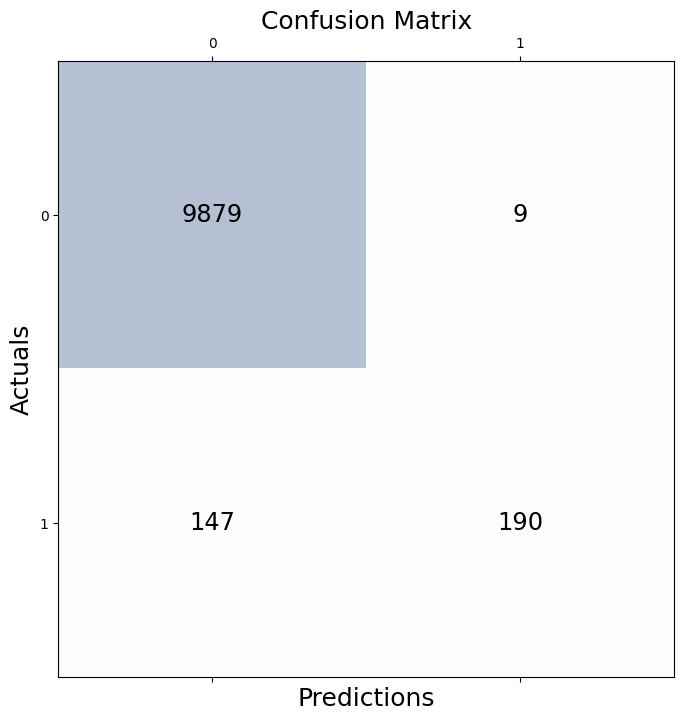

In [45]:
fig1 = create_confusion_matrix(y_october, y_pred_october)

In [47]:
recall_ok = recall_score(y_october, y_pred_october, pos_label=0)
recall_nok = recall_score(y_october, y_pred_october, pos_label=1)
accuracy = accuracy_score(y_october, y_pred_october)

In [48]:
print(f'acc: {accuracy}')
print(f'recall_nok {recall_nok}')
print(f'recall_ok {recall_ok}')

acc: 0.9847432762836186
recall_nok 0.5637982195845698
recall_ok 0.9990898058252428
